In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb

from source import utility as ut
from source import transform as tr
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve, plot_feat_imp, plot_partial_dependence

pd.set_option('max_columns', 100)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

folds = KFold(10, shuffle=True, random_state=541)

In [3]:
train_mean = np.mean(y)
print(f'True Baseline OOF: {round(np.sqrt(mean_squared_error(y, [train_mean]*len(y))), 4)}')
print(f'True Baseline Test: {round(np.sqrt(mean_squared_error(y_test, [train_mean]*len(y_test))), 4)}')

True Baseline OOF: 0.887
True Baseline Test: 0.8883


# Baseline

* Just the necessary to get the model running
* Default hypeparams

In [4]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

Iteations for early stopping: [191, 294, 236, 291, 182, 275, 232, 368, 214, 230]
	Train set RMSE: 0.8454
	Test set RMSE: 0.845


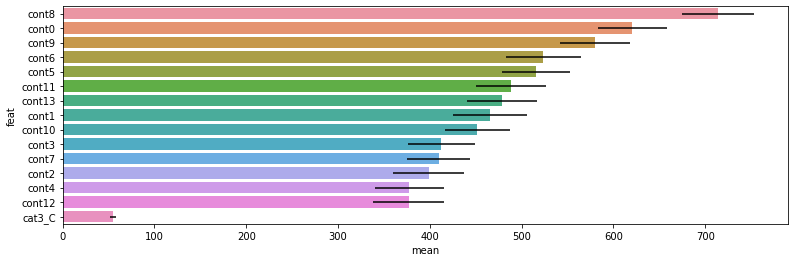

In [9]:
mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

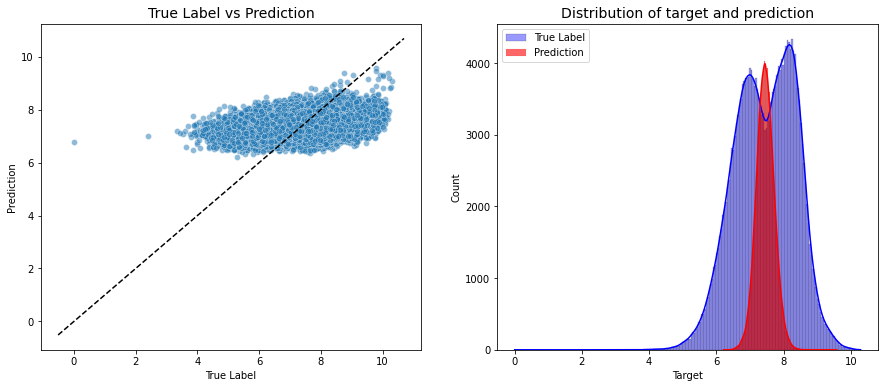

In [7]:
plot_regression_predictions(train_set, y, oof)

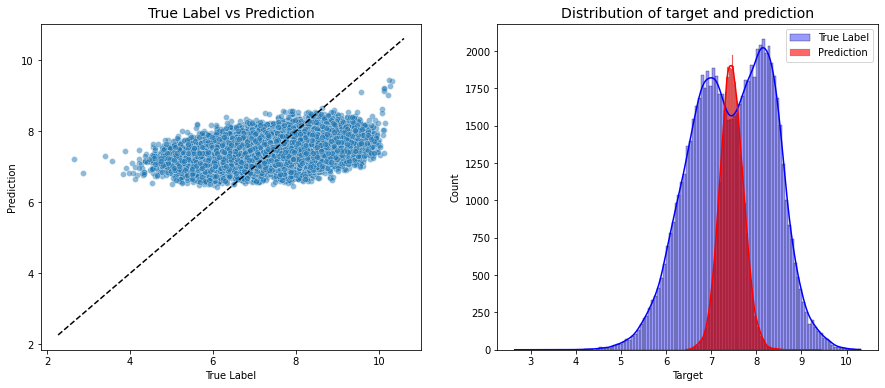

In [8]:
plot_regression_predictions(test_set, y_test, pred)

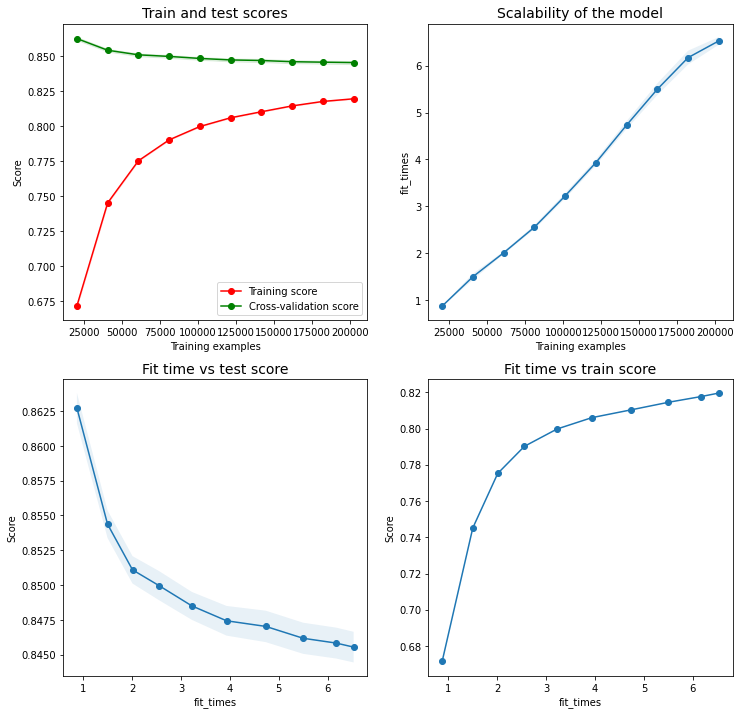

In [10]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=250, n_jobs=1))])

plot_learning_curve(mod_pipe, train_set, y, scoring='neg_root_mean_squared_error', ylim=None, cv=folds,
                        n_jobs=5, train_sizes=np.linspace(.1, 1.0, 10), title=None)

# Target outlier removal

* Removing observations in the train_set with target below 4

Iteations for early stopping: [173, 306, 335, 301, 152, 230, 276, 280, 326, 170]
	Train set RMSE: 0.8446
	Test set RMSE: 0.8451


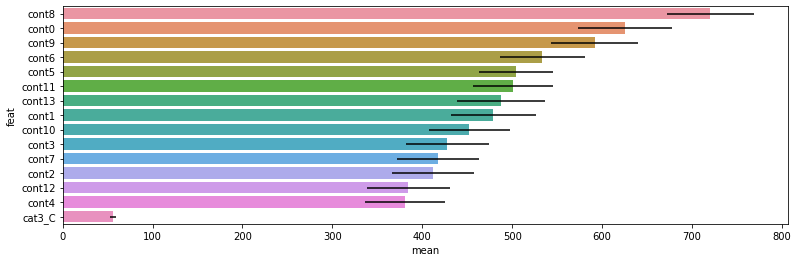

In [13]:
tmp = train_set[y>4]
y_tmp = y[y>4]

mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(tmp, test_set, y_tmp, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y_tmp, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

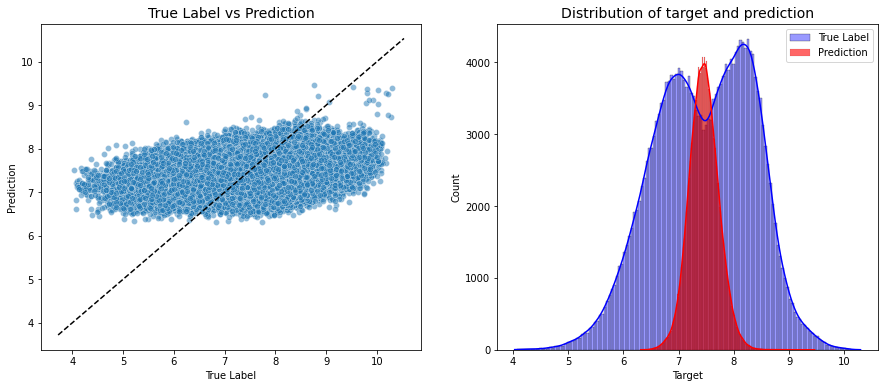

In [15]:
plot_regression_predictions(tmp, y_tmp, oof)

It just improves the cv score, obviously.

# Parameter turning

* Run grid_search on lgb params and use that estimator

In [5]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=250, n_jobs=1))])

param_grid = {'lgb__num_leaves': [10, 30, 60, 120], 
              'lgb__max_depth': [-1, 5, 10, 20], 
              'lgb__min_split_gain': [0, 1, 10], 
              'lgb__subsample': [1, 0.5, 0.7], 
              'lgb__subsample_freq': [1, 5, 10], 
              'lgb__colsample_bytree': [1, 0.8, 0.5], 
              'lgb__reg_alpha': [0, 1, 5, 10], 
              'lgb__reg_lambda': [0, 1, 5, 10]}

res, bp, be = tml.grid_search(data=train_set, target=y, estimator=mod_pipe, scoring='neg_root_mean_squared_error', cv=folds, random=200, param_grid=param_grid)

res.head(25)

,param_lgb__subsample_freq,param_lgb__subsample,param_lgb__reg_lambda,param_lgb__reg_alpha,param_lgb__num_leaves,param_lgb__min_split_gain,param_lgb__max_depth,param_lgb__colsample_bytree,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,5,0.7,10,10,30,1,20,0.8,-0.825657,0.000438,-0.844268,0.003338,8.200898,0.216592,0.512354,0.010474
1,10,1,5,10,30,1,10,0.5,-0.830396,0.000532,-0.844298,0.003302,7.839721,0.152500,0.412152,0.009329
2,5,0.7,10,5,30,0,20,0.5,-0.825206,0.000387,-0.844359,0.003296,8.998408,0.154285,0.475181,0.007548
3,5,1,0,5,30,0,10,0.5,-0.824744,0.000420,-0.844376,0.003431,8.298090,0.166026,0.454397,0.007382
4,1,0.7,5,10,30,0,20,0.8,-0.824545,0.000415,-0.844406,0.003397,8.057166,0.449028,0.492132,0.008539
5,5,1,0,5,120,1,5,0.5,-0.828956,0.000352,-0.844483,0.003302,7.474091,0.124448,0.401915,0.009222
6,1,0.7,10,10,30,0,5,0.8,-0.829074,0.000422,-0.844494,0.003306,6.865222,0.193114,0.411596,0.006792
7,1,1,5,1,30,1,10,0.5,-0.824466,0.000529,-0.844523,0.003476,7.915993,0.115334,0.448786,0.014874
8,5,0.7,10,1,30,0,20,0.5,-0.824273,0.000418,-0.844574,0.003312,8.792085,0.168671,0.454516,0.010143
9,1,1,0,5,60,0,5,0.5,-0.828198,0.000495,-0.844588,0.003414,7.719672,0.139827,0.402889,0.008606


In [6]:
bp = {key.replace('lgb__', ''): value for key,value in bp.items()}
bp

{'subsample_freq': 5,
 'subsample': 0.7,
 'reg_lambda': 10,
 'reg_alpha': 10,
 'num_leaves': 30,
 'min_split_gain': 1,
 'max_depth': 20,
 'colsample_bytree': 0.8}

Iteations for early stopping: [281, 260, 214, 345, 208, 353, 391, 426, 212, 255]
	Train set RMSE: 0.844
	Test set RMSE: 0.8436


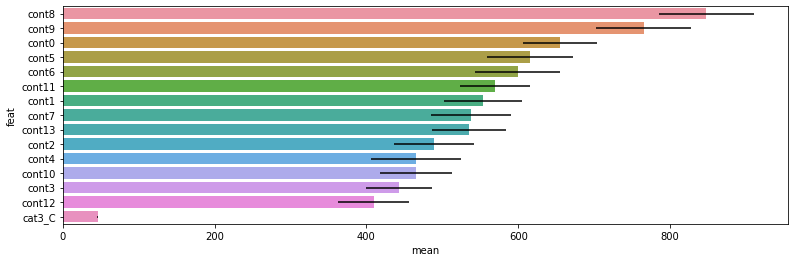

In [7]:
mod = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1, n_jobs=5, **bp)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

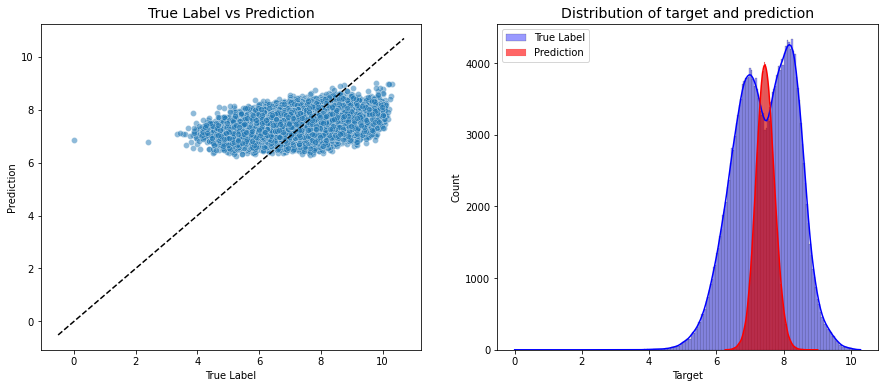

In [8]:
plot_regression_predictions(train_set, y, oof)

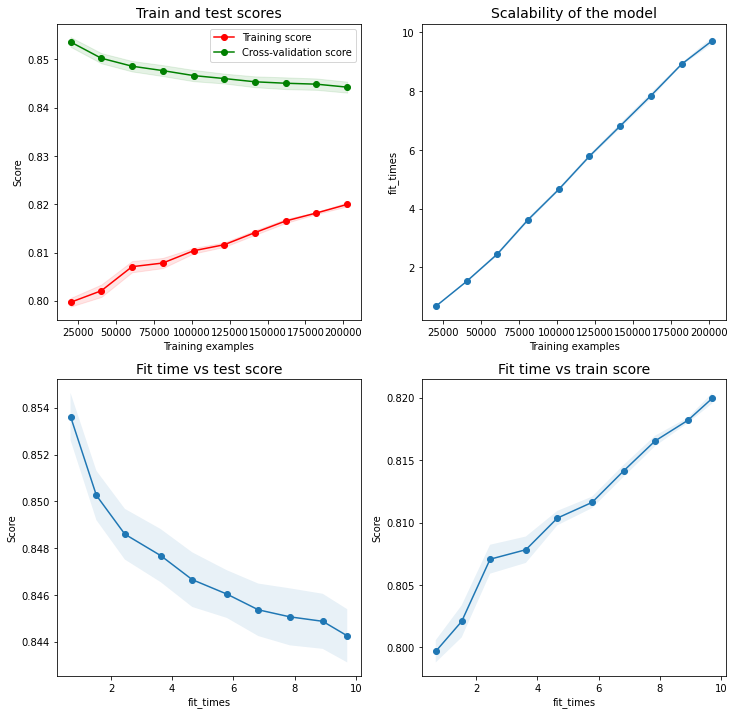

In [9]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=380, n_jobs=1, **bp))])

plot_learning_curve(mod_pipe, train_set, y, scoring='neg_root_mean_squared_error', ylim=None, cv=folds,
                        n_jobs=5, train_sizes=np.linspace(.1, 1.0, 10), title=None)

# Target encoding

* Various agg function and feature group


In [35]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(0,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

In [41]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=250, n_jobs=1))])

param_grid = {'pipe__processing__cat_pipe__tarenc__agg_func': ['mean', 'skew', 'std'], 
              'pipe__processing__cat_pipe__tarenc__to_encode': [[f'cat{c}' for c in range(0,10)], [f'cat{c}' for c in range(3,10)]]
              }

res, bp, be = tml.grid_search(data=train_set, target=y, estimator=mod_pipe, scoring='neg_root_mean_squared_error', cv=folds, param_grid=param_grid)

res.head(15)

,param_pipe__processing__cat_pipe__tarenc__agg_func,param_pipe__processing__cat_pipe__tarenc__to_encode,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,mean,"[cat0, cat1, cat2, cat3, cat4, cat5, cat6, cat...",-0.819326,0.000365,-0.845347,0.003077,7.466470,0.359221,0.409691,0.008349
1,mean,"[cat3, cat4, cat5, cat6, cat7, cat8, cat9]",-0.819326,0.000365,-0.845347,0.003077,7.290646,0.270198,0.408012,0.011828
2,std,"[cat0, cat1, cat2, cat3, cat4, cat5, cat6, cat...",-0.819518,0.000388,-0.845493,0.003270,6.764452,0.459664,0.408020,0.008115
3,std,"[cat3, cat4, cat5, cat6, cat7, cat8, cat9]",-0.819518,0.000388,-0.845493,0.003270,6.645530,0.360040,0.412506,0.025119
4,skew,"[cat0, cat1, cat2, cat3, cat4, cat5, cat6, cat...",-0.819574,0.000336,-0.845494,0.003248,7.472229,0.248179,0.411440,0.008814
5,skew,"[cat3, cat4, cat5, cat6, cat7, cat8, cat9]",-0.819574,0.000336,-0.845494,0.003248,7.307872,0.345139,0.457897,0.046720


Iteations for early stopping: [231, 342, 299, 192, 162, 300, 266, 304, 235, 149]
	Train set RMSE: 0.8452
	Test set RMSE: 0.8452


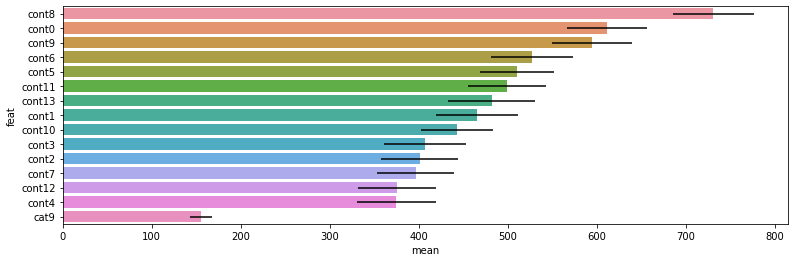

In [36]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(0,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

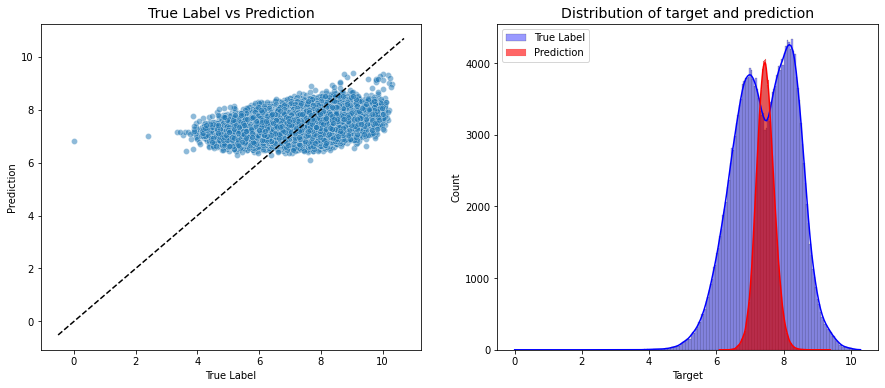

In [37]:
plot_regression_predictions(train_set, y, oof)

# PCA

* Various variances

In [48]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     #('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(3,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler()), 
                      ('pca', tr.PCADf(n_components=0.9, compress=True))])

In [49]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=250, n_jobs=1))])

param_grid = {'pipe__pca__n_components': np.arange(0.7,1, 0.05)
              }

res, bp, be = tml.grid_search(data=train_set, target=y, estimator=mod_pipe, scoring='neg_root_mean_squared_error', cv=folds, param_grid=param_grid)

res.head(15)

,param_pipe__pca__n_components,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.70,-0.82799,0.000395,-0.859786,0.003347,22.170223,0.546738,0.431289,0.047667
1,0.75,-0.82799,0.000395,-0.859786,0.003347,20.973227,0.777894,0.406133,0.017661
2,0.80,-0.82799,0.000395,-0.859786,0.003347,20.144564,0.411883,0.435295,0.040959
3,0.85,-0.82799,0.000395,-0.859786,0.003347,19.776990,1.292011,0.440645,0.053496
4,0.90,-0.82799,0.000395,-0.859786,0.003347,18.500072,1.130564,0.427756,0.023807
5,0.95,-0.82799,0.000395,-0.859786,0.003347,17.981120,0.738070,0.416365,0.031699
6,1.00,-0.82799,0.000395,-0.859786,0.003347,16.659004,1.592630,0.395179,0.018251


Iteations for early stopping: [205, 138, 147, 323, 139, 159, 151, 202, 198, 218]
	Train set RMSE: 0.8595
	Test set RMSE: 0.8588


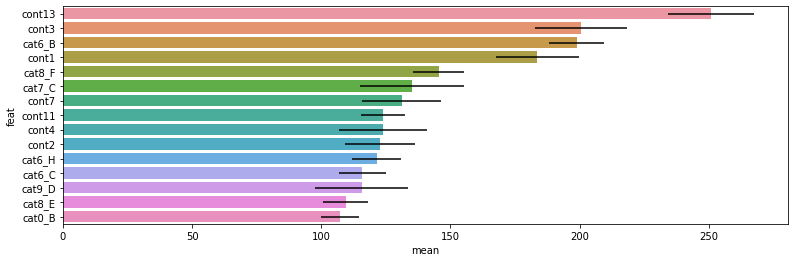

In [50]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     #('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(3,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler()), 
                      ('pca', tr.PCADf(n_components=0.9, compress=True))])

mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

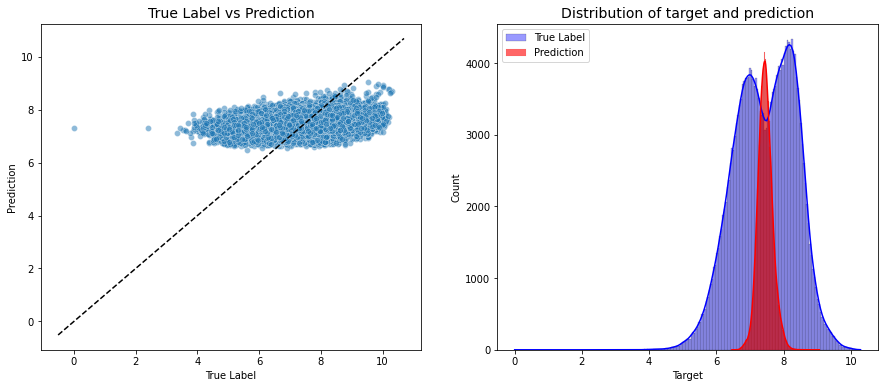

In [51]:
plot_regression_predictions(train_set, y, oof)

# LabelEncoder
* Simple label encoder

In [4]:
le_train = train_set.copy()
le_test = test_set.copy()

for col in [col for col in train_set if 'cat' in col]:
    le = LabelEncoder()
    le_train[col] = le.fit_transform(le_train[col])
    le_test[col] = le.transform(le_test[col])
    
le_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
217278,0,0,0,0,1,3,0,4,6,5,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609
168076,0,0,0,0,1,0,0,4,0,5,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612
85899,1,1,0,2,1,3,0,4,6,12,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128
66230,0,1,0,2,1,3,0,4,6,8,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169
202344,0,0,0,2,1,1,0,4,2,5,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237


Iteations for early stopping: [225, 348, 225, 256, 209, 348, 202, 293, 250, 224]
	Train set RMSE: 0.8454
	Test set RMSE: 0.8449


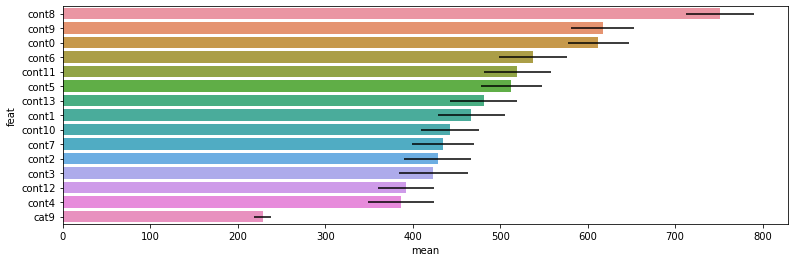

In [8]:
full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

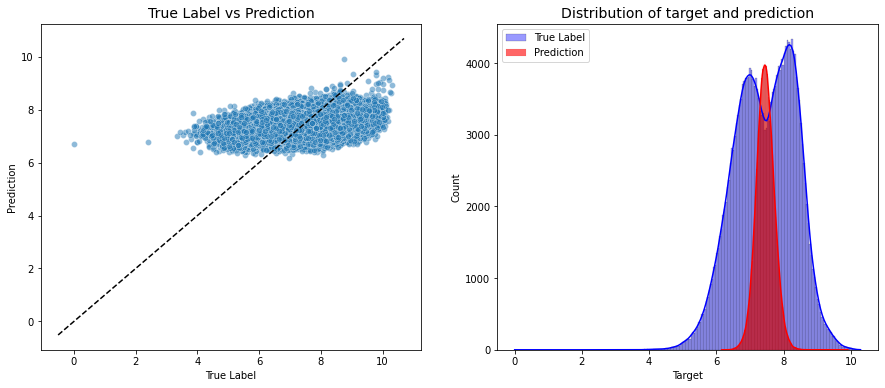

In [9]:
plot_regression_predictions(le_train, y, oof)

* With hyperparams

Iteations for early stopping: [3743, 4572, 3660, 4830, 3580, 4270, 4122, 4042, 3881, 3955]
	Train set RMSE: 0.8422
	Test set RMSE: 0.8428


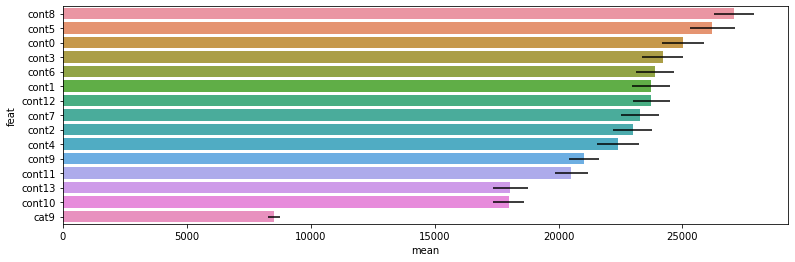

In [9]:
params = { 'random_state':42, 
          'metric': 'rmse', 
          'n_jobs': 5, 
          #'cat_feature': [x for x in range(len(categorical_features))], 
          'bagging_seed':42, 
          'feature_fraction_seed':42, 
          'learning_rate': 0.005, 
          'max_depth': 101, 
          'num_leaves': 86, 
          'reg_alpha': 7.5, 
          'reg_lambda': 1.5, 
          'colsample_bytree': 0.2, 
          'min_child_samples': 149, 
          'subsample_freq': 4, 
          'subsample': 0.5, 
          'max_bin': 720, 
          'min_data_per_group': 55, 
          #'cat_smooth': 78, 
          'cat_l2': 7}

full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=1000, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

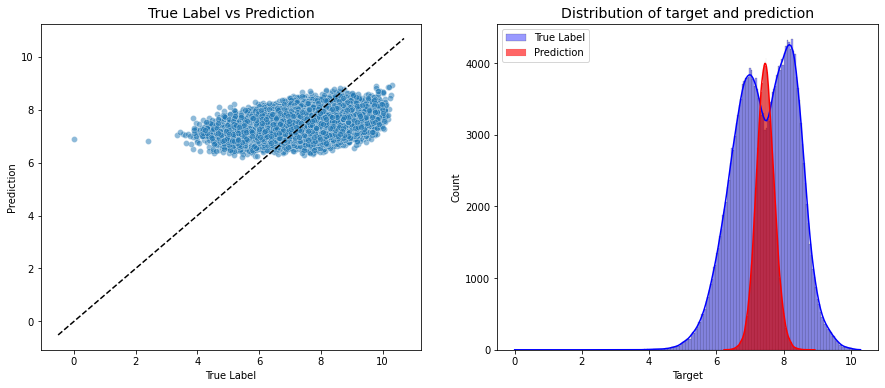

In [10]:
plot_regression_predictions(le_train, y, oof)

Iteations for early stopping: [2422, 2994, 2212, 2805, 2110, 3121, 2812, 2706, 2131, 2189]
	Train set RMSE: 0.8427
	Test set RMSE: 0.8431


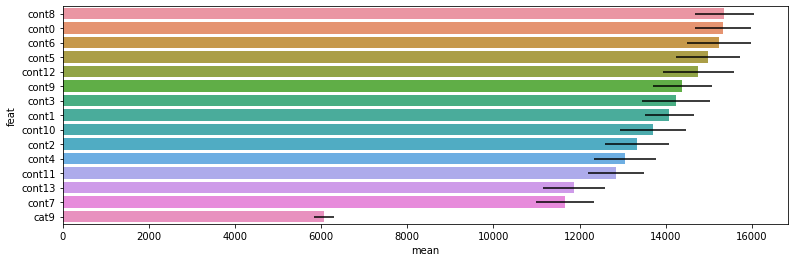

In [7]:
params = { 'reg_lambda': 0.016, 
          'reg_alpha': 9.1, 
          'colsample_bytree': 0.3, 
          'subsample': 1.0, 
          'learning_rate': 0.009, 
          'max_depth': 15, 
          'min_child_samples': 142, 
          'num_leaves': 84, 
          'random_state': 42}

full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=500, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

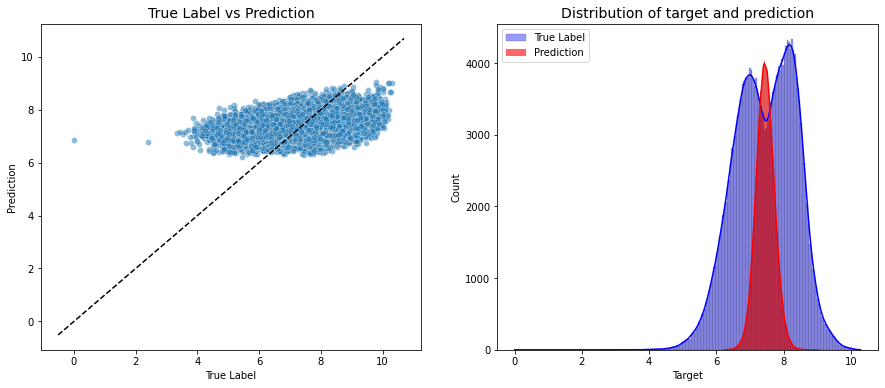

In [15]:
plot_regression_predictions(le_train, y, oof)

Iteations for early stopping: [2441, 2576, 2581, 2833, 2037, 3234, 2836, 2678, 2294, 2643]
	Train set RMSE: 0.8424
	Test set RMSE: 0.8428


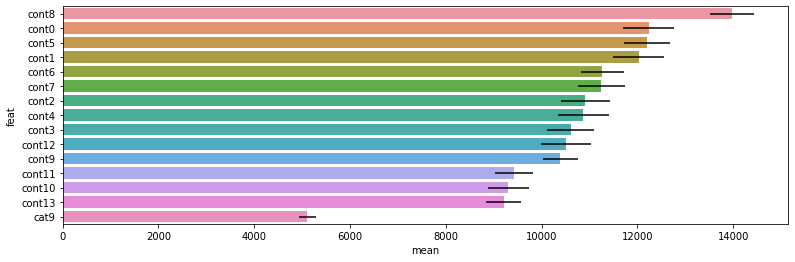

In [8]:
params = {'max_depth': 16, 
               'subsample': 0.8, 
               'colsample_bytree': 0.2, 
               'learning_rate': 0.01, 
               'reg_lambda': 11, 
               'reg_alpha': 17, 
               'min_child_samples': 31, 
               'num_leaves': 66, 
               'max_bin': 522, 
               'cat_smooth': 81, 
               'cat_l2': 0.03, 
               'metric': 'rmse', 
               'n_jobs': 5}


full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = lgb.LGBMRegressor(n_estimators=10000, **params)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=1000, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

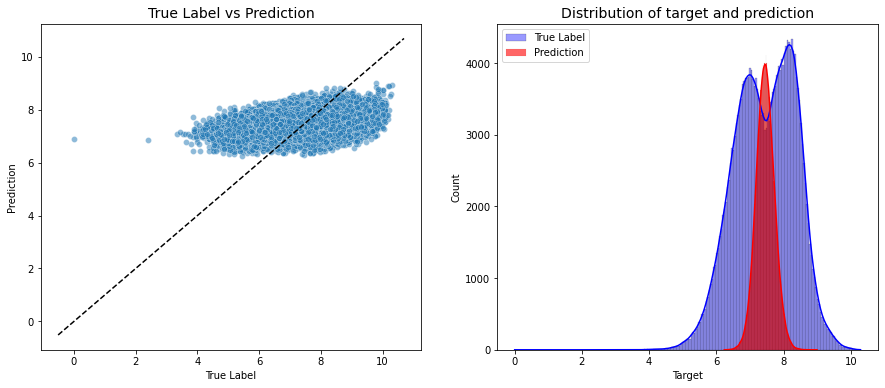

In [9]:
plot_regression_predictions(le_train, y, oof)

Iteations for early stopping: [3485, 4465, 3245, 4108, 2981, 3922, 3827, 3735, 2991, 4013]
	Train set RMSE: 0.8427
	Test set RMSE: 0.8431


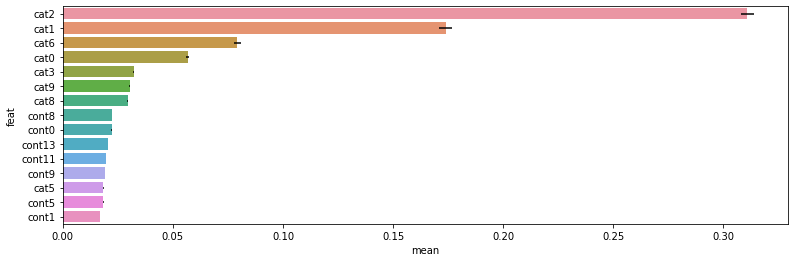

In [10]:
params= {'objective': 'reg:squarederror',
             'max_depth': 6,
             'eta': 0.01,
             'colsample_bytree': 0.4,
             'subsample': 0.6,
             'reg_alpha' : 6,
             'min_child_weight': 100,
             'n_jobs': 5,
             'seed': 2001
            }

full_pipe = Pipeline([('scaler', tml.DfScaler())])

mod = xgb.XGBRegressor(n_estimators=10000, **params)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=1000, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 15)

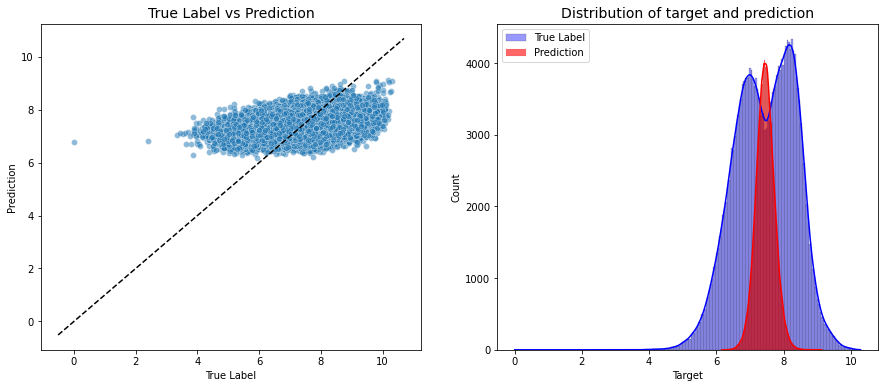

In [11]:
plot_regression_predictions(le_train, y, oof)